In [1]:
import math
import numpy as np
import pandas as pd
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn import linear_model
from sklearn import svm
from sklearn.model_selection import KFold
import numpy.polynomial.polynomial as poly

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression

import keras

/Users/sophia.danielsen/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
%%time

df = pd.read_csv('train.csv', nrows = 10_000, na_values='?', parse_dates=["pickup_datetime"])
display(df.head())
display(df.shape)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1


(10000, 8)

CPU times: user 1.91 s, sys: 32 ms, total: 1.95 s
Wall time: 1.99 s


In [3]:
# Get rid of Outliers
df = df.dropna()

#drop observations with passengers greater than 6 and equals 0
df = df[(df["passenger_count"] > 0 ) & (df["passenger_count"] < 7) ]


#drop observations with fareamount  less than 0 and  greater than 99.99% percentile value.
df = df[(df["fare_amount"] > 0 ) & (df["fare_amount"] < df["fare_amount"].quantile(.9999))]


#drop outlier observations in data
coordinates = ['pickup_longitude','pickup_latitude', 
          'dropoff_longitude', 'dropoff_latitude']
for i in coordinates: 
    df = df[(df[i] > df[i].quantile(.001)) & 
                        (df[i] < df[i].quantile(.999))]
display(df.shape)

(9690, 8)

In [4]:
# add year
df['year'] = df.pickup_datetime.apply(lambda t: t.year)
# add month
df['month'] = df.pickup_datetime.apply(lambda t: t.month)
# add date
df['date'] = df.pickup_datetime.apply(lambda t: t.day)
# add hour
df['hour'] = df.pickup_datetime.apply(lambda t: t.hour)
# add weekday 0:monday, 6:sunday
df['weekday'] = df.pickup_datetime.apply(lambda t: t.weekday())

In [5]:
def distance(start,end):
    dist = []
    R = 6371
    
    for i in range(len(start[0])):
        lat_pu = np.deg2rad(start[1][i])
        lat_do = np.deg2rad(end[1][i])

        dlat = np.deg2rad(end[1][i] - start[1][i])
        dlon =np.deg2rad(end[0][i] - start[0][i])

        a = math.sin(dlat / 2)**2 + math.cos(lat_pu) * math.cos(lat_do) * math.sin(dlon / 2)**2
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
        dist.append(R * c)

    return np.array(dist)


def add_travel_vector_features(df):
    df['abs_diff_longitude'] = (df.dropoff_longitude - df.pickup_longitude).abs()
    df['abs_diff_latitude'] = (df.dropoff_latitude - df.pickup_latitude).abs()

In [6]:
add_travel_vector_features(df)

dist = np.array(df[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']])
pickup = (dist[:,0], dist[:,1])
dropoff = (dist[:,2], dist[:,3])
df['distance'] = distance(pickup, dropoff)

display(df.head())
df = df[(df["distance"] < 1000)]

display(df.head())

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,date,hour,weekday,abs_diff_longitude,abs_diff_latitude,distance
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,15,17,0,0.002701,0.009041,1.030764
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,5,16,1,0.036780,0.070701,8.450134
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,18,0,3,0.008504,0.010708,1.389525
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,21,4,5,0.004437,0.024949,2.799270
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,9,7,1,0.011440,0.015754,1.999157


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,date,hour,weekday,abs_diff_longitude,abs_diff_latitude,distance
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,15,17,0,0.002701,0.009041,1.030764
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,5,16,1,0.036780,0.070701,8.450134
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,18,0,3,0.008504,0.010708,1.389525
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,21,4,5,0.004437,0.024949,2.799270
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,9,7,1,0.011440,0.015754,1.999157


In [7]:
features = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
            'passenger_count', 'year', 'month', 'weekday', 'date', 'hour', 'distance']
X = df[features].values
y = df['fare_amount'].values

# Unsupervised Analysis

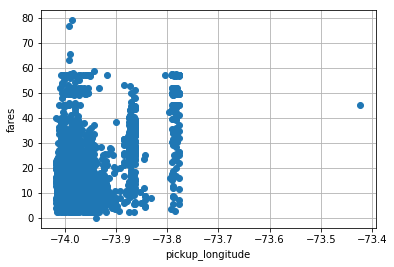

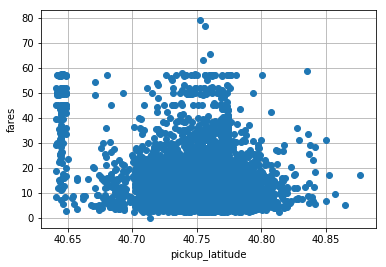

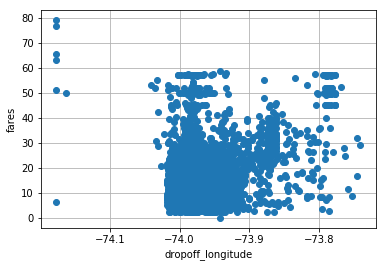

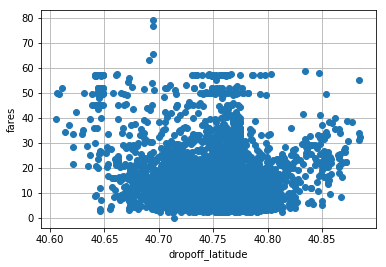

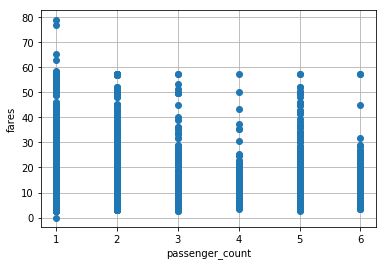

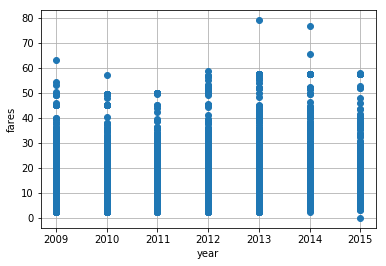

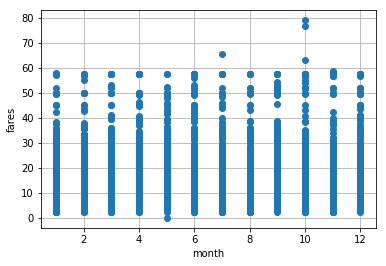

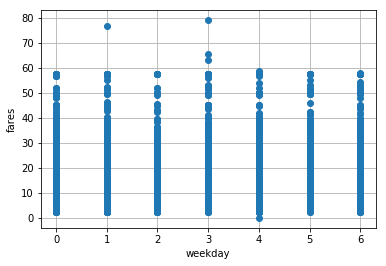

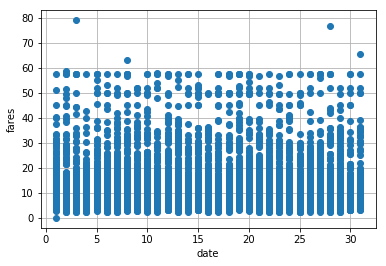

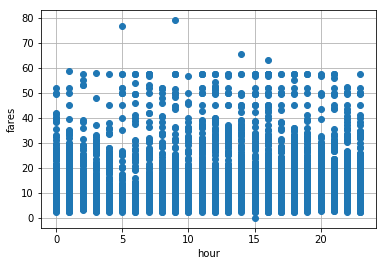

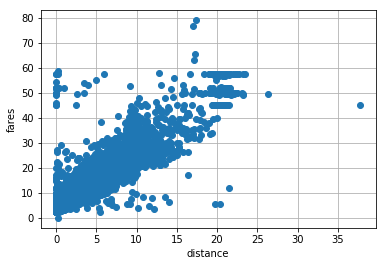

In [8]:
for x in features:
    X = df[x]
    y = df["fare_amount"]

    plt.plot(X,y,'o')
    plt.xlabel(x)
    plt.ylabel('fares')
    plt.grid(True)
    plt.show()

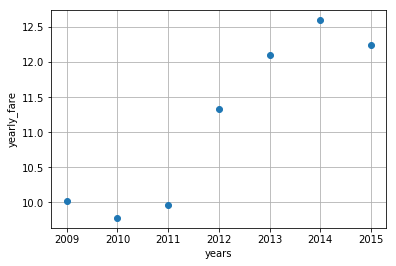

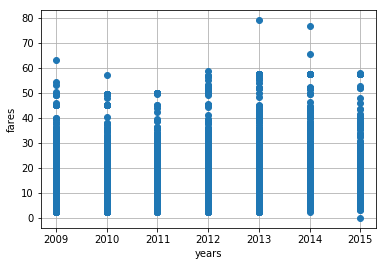

In [9]:
yearly_fare = df.groupby('year').fare_amount.mean()

x = [2009, 2010, 2011, 2012, 2013, 2014, 2015]
y = yearly_fare

plt.plot(x,y,'o')
plt.xlabel("years")
plt.ylabel('yearly_fare')
plt.grid(True)
plt.show()

x = df["year"]
y = df["fare_amount"]

plt.plot(x,y,'o')
plt.xlabel("years")
plt.ylabel('fares')
plt.grid(True)
plt.show()

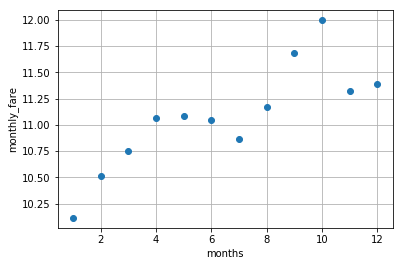

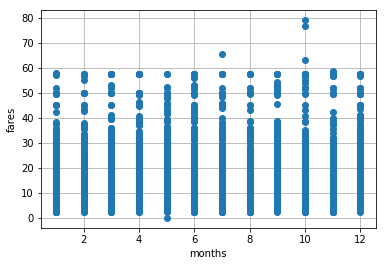

In [10]:
monthly_fare = df.groupby('month').fare_amount.mean()

x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
y = monthly_fare

plt.plot(x,y,'o')
plt.xlabel("months")
plt.ylabel('monthly_fare')
plt.grid(True)
plt.show()

x = df["month"]
y = df["fare_amount"]

plt.plot(x,y,'o')
plt.xlabel("months")
plt.ylabel('fares')
plt.grid(True)
plt.show()

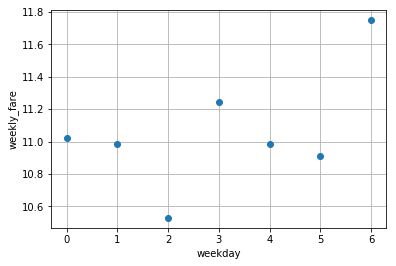

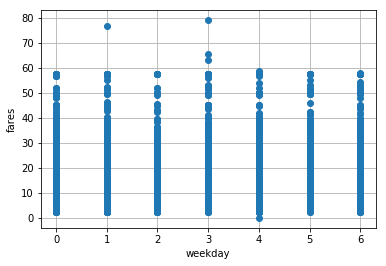

In [11]:
weekly_fare = df.groupby('weekday').fare_amount.mean()

x = [0, 1, 2, 3, 4, 5, 6]
y = weekly_fare

plt.plot(x,y,'o')
plt.xlabel("weekday")
plt.ylabel('weekly_fare')
plt.grid(True)
plt.show()

x = df["weekday"]
y = df["fare_amount"]

plt.plot(x,y,'o')
plt.xlabel("weekday")
plt.ylabel('fares')
plt.grid(True)
plt.show()

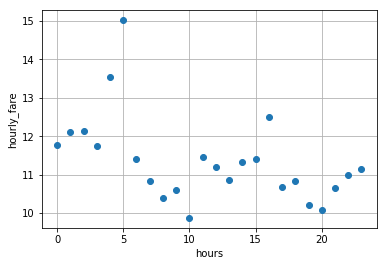

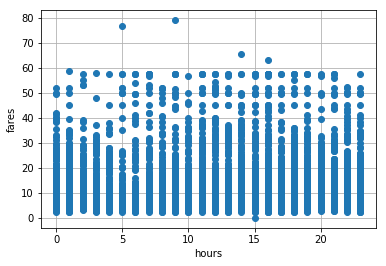

In [12]:
hourly_fare = df.groupby('hour').fare_amount.mean()

x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
y = hourly_fare

plt.plot(x,y,'o')
plt.xlabel("hours")
plt.ylabel('hourly_fare')
plt.grid(True)
plt.show()

x = df["hour"]
y = df["fare_amount"]

plt.plot(x,y,'o')
plt.xlabel("hours")
plt.ylabel('fares')
plt.grid(True)
plt.show()

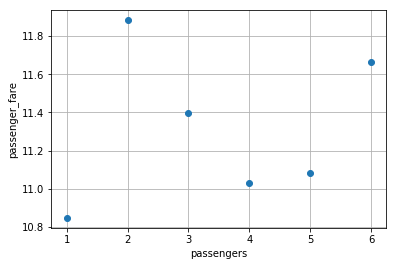

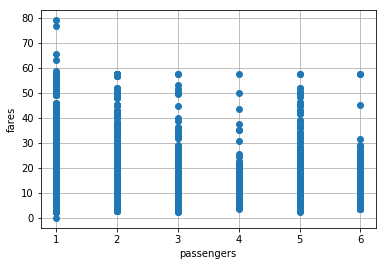

In [13]:
passenger_fare = df.groupby('passenger_count').fare_amount.mean()

x = [1, 2, 3, 4, 5, 6]
y = passenger_fare

plt.plot(x,y,'o')
plt.xlabel("passengers")
plt.ylabel('passenger_fare')
plt.grid(True)
plt.show()

x = df["passenger_count"]
y = df["fare_amount"]

plt.plot(x,y,'o')
plt.xlabel("passengers")
plt.ylabel('fares')
plt.grid(True)
plt.show()

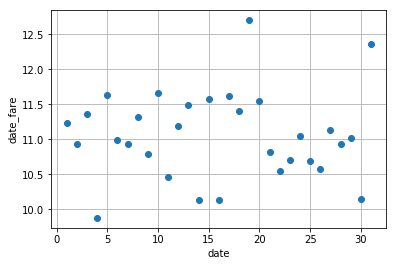

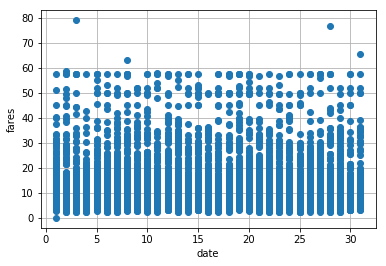

In [14]:
date_fare = df.groupby('date').fare_amount.mean()

x = [i for i in range(1,32)]
y = date_fare

plt.plot(x,y,'o')
plt.xlabel("date")
plt.ylabel('date_fare')
plt.grid(True)
plt.show()

x = df["date"]
y = df["fare_amount"]

plt.plot(x,y,'o')
plt.xlabel("date")
plt.ylabel('fares')
plt.grid(True)
plt.show()

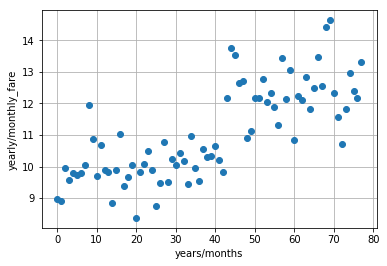

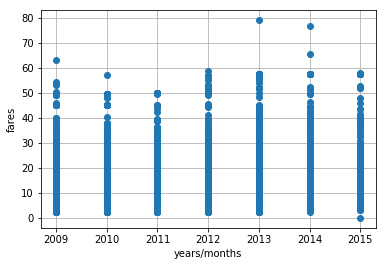

In [15]:
monthly_fare = df.groupby(['year', 'month']).fare_amount.mean()

x = [i for i in range(len(monthly_fare))]
y = monthly_fare

plt.plot(x,y,'o')
plt.xlabel("years/months")
plt.ylabel('yearly/monthly_fare')
plt.grid(True)
plt.show()

x = df["year"]
y = df["fare_amount"]

plt.plot(x,y,'o')
plt.xlabel("years/months")
plt.ylabel('fares')
plt.grid(True)
plt.show()

In [16]:
min_ym = df.groupby(['year', 'month']).min()
print(min_ym)

                                      key  fare_amount     pickup_datetime  \
year month                                                                   
2009 1        2009-01-01 02:51:52.0000002         2.50 2009-01-01 02:51:52   
     2       2009-02-01 02:59:00.00000094         2.50 2009-02-01 02:59:00   
     3        2009-03-01 13:42:48.0000004         3.70 2009-03-01 13:42:48   
     4        2009-04-01 04:18:26.0000001         2.90 2009-04-01 04:18:26   
     5        2009-05-01 20:21:51.0000001         3.30 2009-05-01 20:21:51   
     6        2009-06-01 05:32:25.0000001         2.90 2009-06-01 05:32:25   
     7        2009-07-01 12:20:07.0000001         2.50 2009-07-01 12:20:07   
     8        2009-08-01 03:45:00.0000005         2.50 2009-08-01 03:45:00   
     9       2009-09-01 15:22:00.00000037         2.50 2009-09-01 15:22:00   
     10       2009-10-01 06:43:42.0000001         2.50 2009-10-01 06:43:42   
     11     2009-11-01 00:22:00.000000186         2.50 2009-11-0

# Supervised Analysis

In [ ]:
df.plot.scatter('abs_diff_longitude','abs_diff_latitude')

In [ ]:
df.plot.scatter('distance','fare_amount')

# Linear Model - Linear Regression

In [17]:
overall_best = [-float('inf'),"",0]
data =  [["distance"],
         ["abs_diff_longitude","abs_diff_latitude","distance"],
         ["abs_diff_longitude","abs_diff_latitude","distance","year","month","weekday","date","hour"]]

y = np.array(df["fare_amount"])

LINEAR REGRESSION


Trial 1
Feature set ['distance']
rsq = 0.764228
Coeffients:
 [7.86876702]

Trial 2
Feature set ['abs_diff_longitude', 'abs_diff_latitude', 'distance']
rsq = 0.762059
Coeffients:
 [-1.71657038 -3.84928467 12.73796047]

Trial 3
Feature set ['abs_diff_longitude', 'abs_diff_latitude', 'distance', 'year', 'month', 'weekday', 'date', 'hour']
rsq = 0.775570
Coeffients:
 [-1.85839624 -3.96817584 12.95231523  0.92317053  0.26630495 -0.06875276
  0.02139623  0.08179443]


The best rsq is: 0.7755704801500278
With features: ['abs_diff_longitude', 'abs_diff_latitude', 'distance', 'year', 'month', 'weekday', 'date', 'hour']
--------------------------------------------------------
CPU times: user 125 ms, sys: 14.6 ms, total: 140 ms
Wall time: 82.2 ms


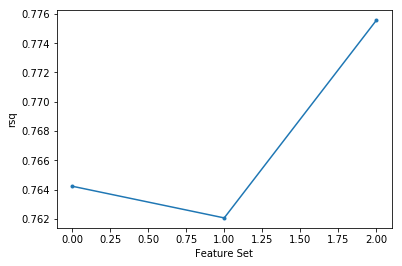

In [18]:
%%time

print("LINEAR REGRESSION\n\n")
best_lin_rsq = -float('inf')
best_lin_data = 0
rsq_linear = []

for i in range(len(data)):
    """Scaling x"""
    x = np.array(df[data[i]])
    x_scale = preprocessing.scale(x)
    
    
    """Splitting data"""
    xtr, xts, ytr, yts = train_test_split(x_scale, y, random_state=0)
    
    
    """Creating model"""
    lm = linear_model.LinearRegression(fit_intercept=True)
    lm.fit(xtr, ytr)
    predictions = lm.predict(xts) #yhat
    
    
    """Printing the rsq"""
    tmp = np.mean((predictions-yts)**2)/(np.std(yts)**2)
    rsq_test = 1-tmp
    rsq_linear.append(rsq_test)
    
    print("Trial", i+1)
    print('Feature set', data[i])
    print("rsq = {0:f}".format(rsq_test))
    print("Coeffients:\n",lm.coef_)
    print('=================')
    print()
    
    
    
    """Updating best rsq"""
    if rsq_test > best_lin_rsq:
        best_lin_rsq = rsq_test
        best_lin_data = i
        if rsq_test > overall_best[0]:
            overall_best = (rsq_test, "Linear", data[i])

            
plt.plot(range(3), rsq_linear, ".-")
plt.xlabel("Feature Set")
plt.ylabel("rsq")

print()
print("The best rsq is:", best_lin_rsq)
print("With features:", data[best_lin_data])
print('--------------------------------------------------------')

# Ridge Regression

LINEAR REGRESSION


Trial 1
Feature set ['distance']
rsq = 0.764228
Coeffients:
 [7.86876702]

Trial 2
Feature set ['abs_diff_longitude', 'abs_diff_latitude', 'distance']
rsq = 0.762059
Coeffients:
 [-1.71657038 -3.84928467 12.73796047]

Trial 3
Feature set ['abs_diff_longitude', 'abs_diff_latitude', 'distance', 'year', 'month', 'weekday', 'date', 'hour']
rsq = 0.775570
Coeffients:
 [-1.85839624 -3.96817584 12.95231523  0.92317053  0.26630495 -0.06875276
  0.02139623  0.08179443]


The best rsq is: 0.7755704801500278
With features: ['abs_diff_longitude', 'abs_diff_latitude', 'distance', 'year', 'month', 'weekday', 'date', 'hour']
--------------------------------------------------------
CPU times: user 87.9 ms, sys: 10.5 ms, total: 98.4 ms
Wall time: 58.5 ms


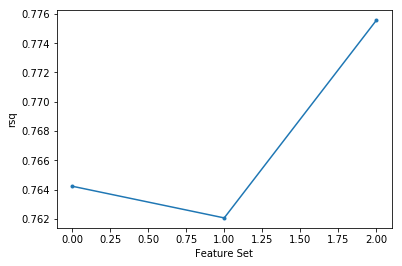

In [19]:
%%time

print("RIDGE REGRESSION\n\n")
best_ridge_rsq = -float('inf')
best_ridge_data = 0
rsq_ridge = []

for i in range(len(data)):
    """Scaling x"""
    x = np.array(df[data[i]])
    x_scale = preprocessing.scale(x)
    
    
    """Splitting data"""
    xtr, xts, ytr, yts = train_test_split(x_scale, y, random_state=0)
    
    
    """Creating model"""
    lm = linear_model.Ridge(fit_intercept=True)
    lm.fit(xtr, ytr)
    predictions = lm.predict(xts) #yhat
    
    
    """Printing the rsq"""
    tmp = np.mean((predictions-yts)**2)/(np.std(yts)**2)
    rsq_test = 1-tmp
    rsq_ridge.append(rsq_test)
    
    print("Trial", i+1)
    print('Feature set', data[i])
    print("rsq = {0:f}".format(rsq_test))
    print("Coeffients:\n",lm.coef_)
    print('=================')
    print()
    
    
    
    """Updating best rsq"""
    if rsq_test > best_ridge_rsq:
        best_ridge_rsq = rsq_test
        best_ridge_data = i
        if rsq_test > overall_best[0]:
            overall_best = (rsq_test, "Ridge", data[i])

            
plt.plot(range(3), rsq_ridge, ".-")
plt.xlabel("Feature Set")
plt.ylabel("rsq")

print()
print("The best rsq is:", best_ridge_rsq)
print("With features:", data[best_ridge_data])
print('--------------------------------------------------------')

# Lasso Regression

LASSO REGRESSION


Trial 1
Feature set ['distance']
rsq = 0.760050
Coeffients:
 [6.85873983]

Trial 2
Feature set ['abs_diff_longitude', 'abs_diff_latitude', 'distance']
rsq = 0.766089
Coeffients:
 [1.60443114 0.         5.42422979]

Trial 3
Feature set ['abs_diff_longitude', 'abs_diff_latitude', 'distance', 'year', 'month', 'weekday', 'date', 'hour']
rsq = 0.766089
Coeffients:
 [ 1.60443114  0.          5.42422979  0.          0.         -0.
 -0.          0.        ]


The best rsq is: 0.7660885170759862
With features: ['abs_diff_longitude', 'abs_diff_latitude', 'distance']
--------------------------------------------------------
CPU times: user 91.4 ms, sys: 9.91 ms, total: 101 ms
Wall time: 55.3 ms


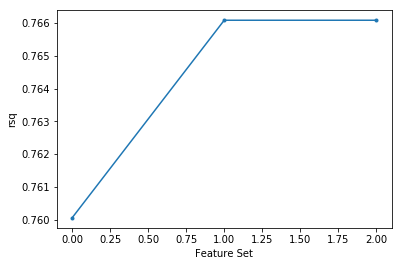

In [20]:
%%time

print("LASSO REGRESSION\n\n")
best_lasso_rsq = -float('inf')
best_lasso_data = 0
rsq_lasso = []

for i in range(len(data)):
    """Scaling x"""
    x = np.array(df[data[i]])
    x_scale = preprocessing.scale(x)
    
    
    """Splitting data"""
    xtr, xts, ytr, yts = train_test_split(x_scale, y, random_state=0)
    
    
    """Creating model"""
    lm = linear_model.Lasso(warm_start=True, fit_intercept=True)
    lm.fit(xtr, ytr)
    predictions = lm.predict(xts) #yhat
    
    
    """Printing the rsq"""
    tmp = np.mean((predictions-yts)**2)/(np.std(yts)**2)
    rsq_test = 1-tmp
    rsq_lasso.append(rsq_test)
    print("Trial", i+1)
    print('Feature set', data[i])
    print("rsq = {0:f}".format(rsq_test))
    print("Coeffients:\n",lm.coef_)
    print('=================')
    print()
    
    
    """Updating best rsq"""
    if rsq_test > best_lasso_rsq:
        best_lasso_rsq = rsq_test
        best_lasso_data = i
        if rsq_test > overall_best[0]:
            overall_best = (rsq_test, "Lasso", data[i])

            
            
plt.plot(range(3), rsq_lasso, ".-")
plt.xlabel("Feature Set")
plt.ylabel("rsq")

print()
print("The best rsq is:", best_lasso_rsq)
print("With features:", data[best_lasso_data])
print('--------------------------------------------------------')

In [21]:
print("The best overall rsq is:", overall_best[0])
print("Using", overall_best[1], "Regression")
print("With feature set:", overall_best[2])

The best overall rsq is: 0.7755704801500278
Using Linear Regression
With feature set: ['abs_diff_longitude', 'abs_diff_latitude', 'distance', 'year', 'month', 'weekday', 'date', 'hour']


# Linear Support Vector Regression (LinearSVR)

In [22]:
x_scale = np.array(df["distance"])
y = np.array(df["fare_amount"])

x_train, x_test, y_train, y_test = train_test_split(x_scale, y, random_state=0)

xtr = x_train.reshape(x_train.shape[0], 1)
ytr = y_train.reshape(x_train.shape[0], 1)

xts = x_test.reshape(x_test.shape[0], 1)
yts = y_test.reshape(y_test.shape[0], 1)

In [23]:
from sklearn.preprocessing import MinMaxScaler

scaling = MinMaxScaler(feature_range=(-1,1)).fit(xtr)
xtr = scaling.transform(xtr)
xts = scaling.transform(xts)

# Linear Support Vector Regression

ytr = y_train.reshape(x_train.shape[0],)
yts = y_test.reshape(y_test.shape[0],)


svr_rbf = svm.SVR(kernel='rbf', C=1e3, gamma=0.1)
svr_lin = svm.SVR(kernel='linear', C=1e3)
svr_poly = svm.SVR(kernel='poly', C=1e3, degree=2)

svr_rbf.fit(xtr, ytr)
svr_lin.fit(xtr, ytr)
svr_poly.fit(xtr, ytr)
    
yhat_rbf = svr_rbf.predict(xts)
yhat_lin = svr_lin.predict(xts)
yhat_poly = svr_poly.predict(xts)
    
tmp = np.mean((yhat_rbf-yts)**2)/(np.std(yts)**2)
rsq_test = 1-tmp
print("rsq_rbf = {0:f}".format(rsq_test))

tmp = np.mean((yhat_lin-yts)**2)/(np.std(yts)**2)
rsq_test = 1-tmp
print("rsq_lin = {0:f}".format(rsq_test))

tmp = np.mean((yhat_poly-yts)**2)/(np.std(yts)**2)
rsq_test = 1-tmp
print("rsq_poly = {0:f}".format(rsq_test))

rsq_rbf = 0.764555
rsq_lin = 0.760277
rsq_poly = 0.445071


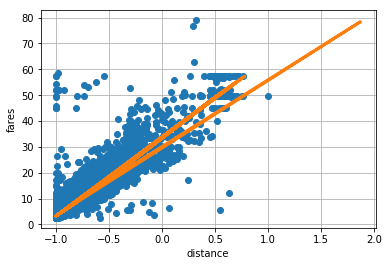

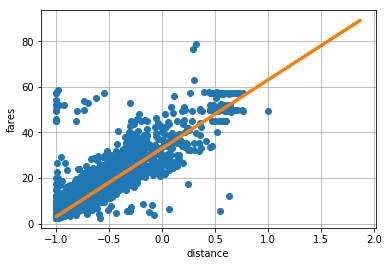

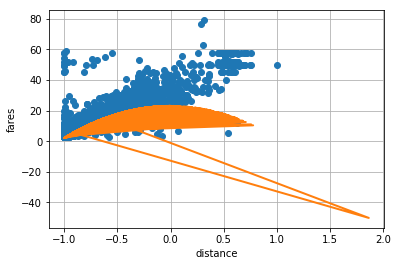

In [24]:
plt.plot(xtr,ytr,'o')
plt.plot(xts,yhat_rbf,'-',linewidth=3)
plt.xlabel("distance")
plt.ylabel('fares')
plt.grid(True)
plt.show()

plt.plot(xtr,ytr,'o')
plt.plot(xts,yhat_lin,'-',linewidth=3)
plt.xlabel("distance")
plt.ylabel('fares')
plt.grid(True)
plt.show()

plt.plot(xtr,ytr,'o')
plt.plot(xts,yhat_poly,'-',linewidth=2)
plt.xlabel("distance")
plt.ylabel('fares')
plt.grid(True)
plt.show()

# Kfold Cross Validation


In [25]:
def kfold_cross_validation_rbf(a, y):
    alpha = np.linspace(0.0001, 1, 20)
    print("All possible alphas:", alpha)
    best_alpha = 0
    kfold_model = KFold(n_splits=5, random_state=None, shuffle=False)
    min_error = float('inf')
    for alp in alpha:
        error = []
        print("testing alpha:", alp)
        for train_index, test_index in kfold_model.split(a):
            X_tr = a[train_index]
            Y_tr = y[train_index].reshape((-1, 1))
            X_ts = a[test_index]
            Y_ts = y[test_index].reshape((-1, 1))
            
            svr_rbf = svm.SVR(kernel = 'rbf', C = alp)
            svr_rbf.fit(xtr, ytr)
            yhat = svr_rbf.predict(xts)
    
            tmp = np.mean((yhat-yts)**2)/(np.std(yts)**2)
            rsq_test = 1-tmp
            #print("rsq = {0:f}".format(rsq_test))
    
            error.append(np.sum((yts-yhat)**2))
        if (np.mean(error) < min_error):
            min_error = np.mean(error)
            best_alpha = alp
            print(min_error)
            print("rsq = {0:f}".format(rsq_test))
            
    return best_alpha

In [26]:
def kfold_cross_validation_lin(a, y):
    alpha = np.linspace(0.0001, 1, 20)
    print("All possible alphas:", alpha)
    best_alpha = 0
    kfold_model = KFold(n_splits=5, random_state=None, shuffle=False)
    min_error = float('inf')
    for alp in alpha:
        error = []
        print("testing alpha:", alp)
        for train_index, test_index in kfold_model.split(a):
            X_tr = a[train_index]
            Y_tr = y[train_index].reshape((-1, 1))
            X_ts = a[test_index]
            Y_ts = y[test_index].reshape((-1, 1))
            
            svr_lin = svm.SVR(kernel = 'linear', C = alp)
            svr_lin.fit(xtr, ytr)
            yhat = svr_lin.predict(xts)
    
            tmp = np.mean((yhat-yts)**2)/(np.std(yts)**2)
            rsq_test = 1-tmp
            #print("rsq = {0:f}".format(rsq_test))
    
            error.append(np.sum((yts-yhat)**2))
        if (np.mean(error) < min_error):
            min_error = np.mean(error)
            best_alpha = alp
            print(min_error)
            print("rsq = {0:f}".format(rsq_test))
            
    return best_alpha

In [27]:
def kfold_cross_validation_poly(a, y):
    alpha = np.linspace(0.0001, 1, 20)
    print("All possible alphas:", alpha)
    best_alpha = 0
    kfold_model = KFold(n_splits=5, random_state=None, shuffle=False)
    min_error = float('inf')
    for alp in alpha:
        error = []
        print("testing alpha:", alp)
        for train_index, test_index in kfold_model.split(a):
            X_tr = a[train_index]
            Y_tr = y[train_index].reshape((-1, 1))
            X_ts = a[test_index]
            Y_ts = y[test_index].reshape((-1, 1))
            
            svr_poly = svm.SVR(kernel = 'poly', degree = 2, C = alp)
            svr_poly.fit(xtr, ytr)
            yhat = svr_poly.predict(xts)
    
            tmp = np.mean((yhat-yts)**2)/(np.std(yts)**2)
            rsq_test = 1-tmp
#             print("rsq = {0:f}".format(rsq_test))
            
            error.append(np.sum((yts-yhat)**2))
        if (np.mean(error) < min_error):
            min_error = np.mean(error)
            best_alpha = alp
            print(min_error)
            print("rsq = {0:f}".format(rsq_test))
            
    return best_alpha

In [28]:
alpha_rbf = kfold_cross_validation_rbf(x_scale, y)
alpha_lin = kfold_cross_validation_lin(x_scale, y)
alpha_poly = kfold_cross_validation_poly(x_scale, y)

All possible alphas: [1.00000000e-04 5.27263158e-02 1.05352632e-01 1.57978947e-01
 2.10605263e-01 2.63231579e-01 3.15857895e-01 3.68484211e-01
 4.21110526e-01 4.73736842e-01 5.26363158e-01 5.78989474e-01
 6.31615789e-01 6.84242105e-01 7.36868421e-01 7.89494737e-01
 8.42121053e-01 8.94747368e-01 9.47373684e-01 1.00000000e+00]
testing alpha: 0.0001
198838.66309484743
rsq = -0.080630
testing alpha: 0.05272631578947369
61549.872265386264
rsq = 0.665495
testing alpha: 0.10535263157894738
50839.087614352175
rsq = 0.723704
testing alpha: 0.15797894736842105
46541.29963769879
rsq = 0.747062
testing alpha: 0.21060526315789474
44508.42879721796
rsq = 0.758110
testing alpha: 0.2632315789473684
43107.4641971447
rsq = 0.765724
testing alpha: 0.3158578947368421
42888.08647510105
rsq = 0.766916
testing alpha: 0.3684842105263158
42647.49581311917
rsq = 0.768223
testing alpha: 0.4211105263157895
42424.117512436584
rsq = 0.769437
testing alpha: 0.4737368421052632
42216.4407466361
rsq = 0.770566
testing 

Best Alpha =  0.7894947368421052
rsq = 0.770851


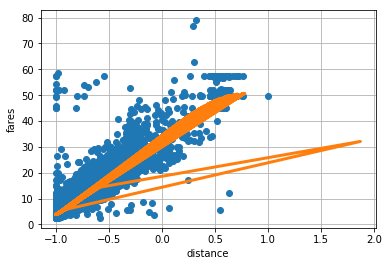

In [46]:
svr_rbf = svm.SVR(kernel = 'rbf', C = alpha_rbf)
svr_rbf.fit(xtr, ytr)
    
yhat_rbf = svr_rbf.predict(xts)

print("Best Alpha = ", alpha_rbf)

tmp = np.mean((yhat_rbf-yts)**2)/(np.std(yts)**2)
rsq_test = 1-tmp
print("rsq = {0:f}".format(rsq_test))
    
plt.plot(xtr,ytr,'o')
plt.plot(xts,yhat_rbf,'-',linewidth=3)
plt.xlabel("distance")
plt.ylabel('fares')
plt.grid(True)
plt.show()

Best Alpha =  0.5789894736842105
rsq = 0.760885


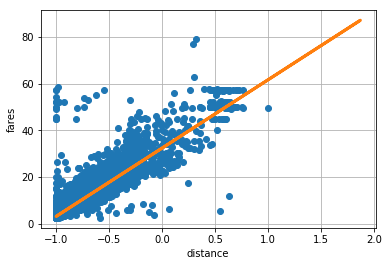

In [48]:
svr_lin = svm.SVR(kernel = 'linear', C = alpha_lin)
svr_lin.fit(xtr, ytr)
    
yhat_lin = svr_lin.predict(xts)

print("Best Alpha = ", alpha_lin)
    
tmp = np.mean((yhat_lin-yts)**2)/(np.std(yts)**2)
rsq_test = 1-tmp
print("rsq = {0:f}".format(rsq_test))
    
plt.plot(xtr,ytr,'o')
plt.plot(xts,yhat_lin,'-',linewidth=3)
plt.xlabel("distance")
plt.ylabel('fares')
plt.grid(True)
plt.show()

Best Alpha =  1.0
rsq = 0.443589


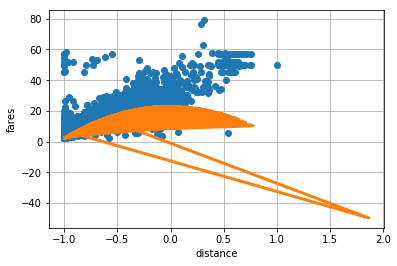

In [50]:
svr_poly = svm.SVR(kernel = 'poly', degree = 2, C = alpha_poly)
svr_poly.fit(xtr, ytr)
    
yhat_poly = svr_poly.predict(xts)

print("Best Alpha = ", alpha_poly)
    
tmp = np.mean((yhat_poly-yts)**2)/(np.std(yts)**2)
rsq_test = 1-tmp
print("rsq = {0:f}".format(rsq_test))
    
plt.plot(xtr,ytr,'o')
plt.plot(xts,yhat_poly,'-',linewidth=3)
plt.xlabel("distance")
plt.ylabel('fares')
plt.grid(True)
plt.show()

# Neural Network (Linear Rregression)

In [32]:
from keras.models import Model, Sequential
from keras.layers import Dense, Activation

In [33]:
import keras.backend as K
K.clear_session()

In [34]:
x_scale = np.array(df["distance"])
y = np.array(df["fare_amount"])

x_train, x_test, y_train, y_test = train_test_split(x_scale, y, random_state=0)

x_train = x_train.reshape(x_train.shape[0], 1)
x_test = x_test.reshape(x_test.shape[0], 1)

y_train = y_train.reshape(x_train.shape[0], 1)
y_test = y_test.reshape(y_test.shape[0], 1)

In [35]:
nin = x_train.shape[1]  # dimension of input data
nh = 200     # number of hidden units
nout = 1
model = Sequential()
model.add(Dense(nh, input_shape=(nin,), activation='linear'))
model.add(Dense(nout, activation='linear'))

In [36]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               400       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 201       
Total params: 601
Trainable params: 601
Non-trainable params: 0
_________________________________________________________________


In [37]:
import tensorflow as tf
from keras import optimizers

opt = tf.train.RMSPropOptimizer(0.001)

model.compile(loss='mse', optimizer=opt ,  metrics = ['mse'])
model.fit(x_train, y_train, epochs=10, batch_size=100, validation_data=(x_test,y_test))

Train on 7267 samples, validate on 2423 samples
Epoch 1/10
7267/7267 [==============================] - 0s 36us/step - loss: 52.1169 - mean_squared_error: 52.1169 - val_loss: 21.1113 - val_mean_squared_error: 21.1113
Epoch 2/10
7267/7267 [==============================] - 0s 12us/step - loss: 18.1258 - mean_squared_error: 18.1258 - val_loss: 18.3628 - val_mean_squared_error: 18.3628
Epoch 3/10
7267/7267 [==============================] - 0s 13us/step - loss: 16.9660 - mean_squared_error: 16.9660 - val_loss: 17.9511 - val_mean_squared_error: 17.9511
Epoch 4/10
7267/7267 [==============================] - 0s 11us/step - loss: 16.9121 - mean_squared_error: 16.9121 - val_loss: 18.2224 - val_mean_squared_error: 18.2224
Epoch 5/10
7267/7267 [==============================] - 0s 12us/step - loss: 16.8872 - mean_squared_error: 16.8872 - val_loss: 18.1614 - val_mean_squared_error: 18.1614
Epoch 6/10
7267/7267 [==============================] - 0s 12us/step - loss: 16.8801 - mean_squared_error: 

In [38]:
yhat = model.predict(x_test)

In [39]:
print(yhat)

[[21.597576]
 [11.555359]
 [16.575897]
 ...
 [14.54875 ]
 [ 7.781425]
 [21.84203 ]]


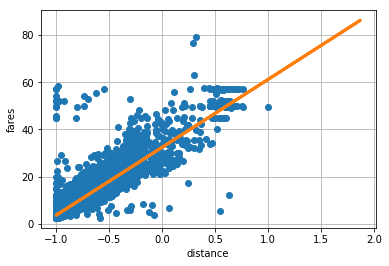

In [40]:
plt.plot(xtr,ytr,'o')
plt.plot(xts,yhat,'-',linewidth=3)
plt.xlabel("distance")
plt.ylabel('fares')
plt.grid(True)
plt.show()

In [41]:
tmp = np.mean((yhat-y_test)**2)/(np.std(y_test)**2)
rsq_test = 1-tmp
print("rsq = {0:f}".format(rsq_test))

rsq = 0.765275


Train on 7267 samples, validate on 2423 samples
Epoch 1/10
7267/7267 [==============================] - 0s 30us/step - loss: 116.5150 - mean_squared_error: 116.5150 - val_loss: 41.8809 - val_mean_squared_error: 41.8809
Epoch 2/10
7267/7267 [==============================] - 0s 11us/step - loss: 23.1546 - mean_squared_error: 23.1546 - val_loss: 19.8888 - val_mean_squared_error: 19.8888
Epoch 3/10
7267/7267 [==============================] - 0s 12us/step - loss: 17.4076 - mean_squared_error: 17.4076 - val_loss: 18.3139 - val_mean_squared_error: 18.3139
Epoch 4/10
7267/7267 [==============================] - 0s 11us/step - loss: 16.8941 - mean_squared_error: 16.8941 - val_loss: 18.0976 - val_mean_squared_error: 18.0976
Epoch 5/10
7267/7267 [==============================] - 0s 11us/step - loss: 16.8314 - mean_squared_error: 16.8314 - val_loss: 17.8640 - val_mean_squared_error: 17.8640
Epoch 6/10
7267/7267 [==============================] - 0s 11us/step - loss: 16.8554 - mean_squared_error

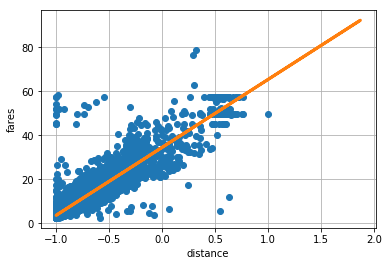

rsq = 0.758796


In [42]:
K.clear_session()

nin = x_train.shape[1]  # dimension of input data
nh = 100     # number of hidden units
nout = 1
model = Sequential()
model.add(Dense(nh, input_shape=(nin,), activation='linear'))
model.add(Dense(nout, activation='linear'))

import tensorflow as tf
from keras import optimizers

opt = tf.train.RMSPropOptimizer(0.001)

model.compile(loss='mse', optimizer=opt ,  metrics = ['mse'])
model.fit(x_train, y_train, epochs=10, batch_size=100, validation_data=(x_test,y_test))

yhat = model.predict(x_test)

plt.plot(xtr,ytr,'o')
plt.plot(xts,yhat,'-',linewidth=3)
plt.xlabel("distance")
plt.ylabel('fares')
plt.grid(True)
plt.show()

tmp = np.mean((yhat-y_test)**2)/(np.std(y_test)**2)
rsq_test = 1-tmp
print("rsq = {0:f}".format(rsq_test))

Train on 7267 samples, validate on 2423 samples
Epoch 1/10
7267/7267 [==============================] - 0s 30us/step - loss: 123.9695 - mean_squared_error: 123.9695 - val_loss: 64.8529 - val_mean_squared_error: 64.8529
Epoch 2/10
7267/7267 [==============================] - 0s 14us/step - loss: 37.0109 - mean_squared_error: 37.0109 - val_loss: 20.9591 - val_mean_squared_error: 20.9591
Epoch 3/10
7267/7267 [==============================] - 0s 16us/step - loss: 18.4067 - mean_squared_error: 18.4067 - val_loss: 19.6021 - val_mean_squared_error: 19.6021
Epoch 4/10
7267/7267 [==============================] - 0s 14us/step - loss: 17.3375 - mean_squared_error: 17.3375 - val_loss: 18.5577 - val_mean_squared_error: 18.5577
Epoch 5/10
7267/7267 [==============================] - 0s 13us/step - loss: 16.9292 - mean_squared_error: 16.9292 - val_loss: 17.9843 - val_mean_squared_error: 17.9843
Epoch 6/10
7267/7267 [==============================] - 0s 14us/step - loss: 16.8090 - mean_squared_error

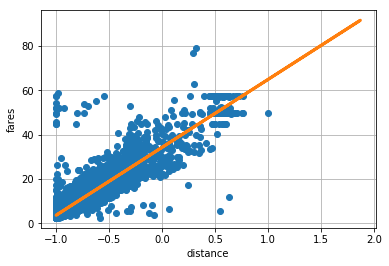

rsq = 0.760457


In [61]:
K.clear_session()

nin = x_train.shape[1]  # dimension of input data
nh = 50     # number of hidden units
nout = 1
model = Sequential()
model.add(Dense(nh, input_shape=(nin,), activation='linear'))
model.add(Dense(nout, activation='linear'))

import tensorflow as tf
from keras import optimizers

opt = tf.train.RMSPropOptimizer(0.001)

model.compile(loss='mse', optimizer=opt ,  metrics = ['mse'])
model.fit(x_train, y_train, epochs=10, batch_size=100, validation_data=(x_test,y_test))

yhat = model.predict(x_test)

plt.plot(xtr,ytr,'o')
plt.plot(xts,yhat,'-',linewidth=3)
plt.xlabel("distance")
plt.ylabel('fares')
plt.grid(True)
plt.show()

tmp = np.mean((yhat-y_test)**2)/(np.std(y_test)**2)
rsq_test = 1-tmp
print("rsq = {0:f}".format(rsq_test))

Train on 7267 samples, validate on 2423 samples
Epoch 1/10
7267/7267 [==============================] - 1s 74us/step - loss: 26.4655 - mean_squared_error: 26.4655 - val_loss: 18.9933 - val_mean_squared_error: 18.9933
Epoch 2/10
7267/7267 [==============================] - 0s 39us/step - loss: 18.1835 - mean_squared_error: 18.1835 - val_loss: 18.9922 - val_mean_squared_error: 18.9922
Epoch 3/10
7267/7267 [==============================] - 0s 39us/step - loss: 18.0272 - mean_squared_error: 18.0272 - val_loss: 24.3181 - val_mean_squared_error: 24.3181
Epoch 4/10
7267/7267 [==============================] - 0s 43us/step - loss: 17.7622 - mean_squared_error: 17.7622 - val_loss: 21.3766 - val_mean_squared_error: 21.3766
Epoch 5/10
7267/7267 [==============================] - 0s 38us/step - loss: 17.7625 - mean_squared_error: 17.7625 - val_loss: 17.8530 - val_mean_squared_error: 17.8530
Epoch 6/10
7267/7267 [==============================] - 0s 49us/step - loss: 17.5539 - mean_squared_error: 

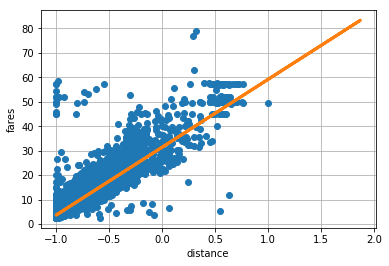

rsq = 0.762808


In [53]:
K.clear_session()

nin = x_train.shape[1]  # dimension of input data
nh = 200     # number of hidden units
nh2 = 300
nout = 1
model = Sequential()
model.add(Dense(nh, input_shape=(nin,), activation='linear'))
model.add(Dense(nh2, activation='linear'))
model.add(Dense(nout, activation='linear'))

import tensorflow as tf
from keras import optimizers

opt = tf.train.RMSPropOptimizer(0.001)

model.compile(loss='mse', optimizer=opt ,  metrics = ['mse'])
model.fit(x_train, y_train, epochs=10, batch_size=100, validation_data=(x_test,y_test))

yhat = model.predict(x_test)

plt.plot(xtr,ytr,'o')
plt.plot(xts,yhat,'-',linewidth=3)
plt.xlabel("distance")
plt.ylabel('fares')
plt.grid(True)
plt.show()

tmp = np.mean((yhat-y_test)**2)/(np.std(y_test)**2)
rsq_test = 1-tmp
print("rsq = {0:f}".format(rsq_test))

Train on 7267 samples, validate on 2423 samples
Epoch 1/10
7267/7267 [==============================] - 1s 91us/step - loss: 26.3778 - mean_squared_error: 26.3778 - val_loss: 18.7438 - val_mean_squared_error: 18.7438
Epoch 2/10
7267/7267 [==============================] - 1s 70us/step - loss: 20.0536 - mean_squared_error: 20.0536 - val_loss: 18.7159 - val_mean_squared_error: 18.7159
Epoch 3/10
7267/7267 [==============================] - 1s 95us/step - loss: 18.8359 - mean_squared_error: 18.8359 - val_loss: 18.1142 - val_mean_squared_error: 18.1142
Epoch 4/10
7267/7267 [==============================] - 1s 78us/step - loss: 18.1680 - mean_squared_error: 18.1680 - val_loss: 18.3648 - val_mean_squared_error: 18.3648
Epoch 5/10
7267/7267 [==============================] - 0s 64us/step - loss: 18.1805 - mean_squared_error: 18.1805 - val_loss: 20.8786 - val_mean_squared_error: 20.8786
Epoch 6/10
7267/7267 [==============================] - 0s 63us/step - loss: 17.8242 - mean_squared_error: 

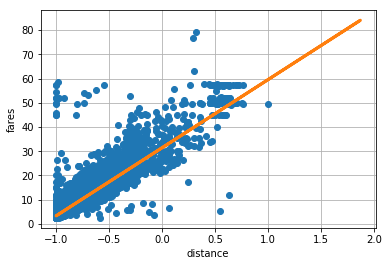

rsq = 0.759854


In [63]:
K.clear_session()

nin = x_train.shape[1]  # dimension of input data
nh = 400     # number of hidden units
nh2 = 500
nout = 1
model = Sequential()
model.add(Dense(nh, input_shape=(nin,), activation='linear'))
model.add(Dense(nh2, activation='linear'))
model.add(Dense(nout, activation='linear'))

import tensorflow as tf
from keras import optimizers

opt = tf.train.RMSPropOptimizer(0.001)

model.compile(loss='mse', optimizer=opt ,  metrics = ['mse'])
model.fit(x_train, y_train, epochs=10, batch_size=100, validation_data=(x_test,y_test))

yhat = model.predict(x_test)

plt.plot(xtr,ytr,'o')
plt.plot(xts,yhat,'-',linewidth=3)
plt.xlabel("distance")
plt.ylabel('fares')
plt.grid(True)
plt.show()

tmp = np.mean((yhat-y_test)**2)/(np.std(y_test)**2)
rsq_test = 1-tmp
print("rsq = {0:f}".format(rsq_test))